In [1]:
import numpy as np

import PySoap2
from PySoap2.models import Model

In [20]:
import pandas as pd

In [36]:
mask1 = np.array([x < 50 for x in range(100)])
mask2 = np.array([x < 25 for x in range(50)])

In [62]:
input_layer = PySoap2.layers.Input(input_shape=(28, 28))
layer1 = PySoap2.layers.Flatten()(input_layer)
layer2 = PySoap2.layers.Dense(100, 'relu')(layer1)

layer3 = PySoap2.layers.Split(mask1)(layer2)

layer5 = PySoap2.layers.Split(mask2)(layer3.left)
layer6 = PySoap2.layers.Dense(10, 'relu')(layer5.right)
layer4 = PySoap2.layers.Dense(10, 'relu')(layer5.left)

layer7 = PySoap2.layers.Concatenate(axis=-1)([layer4, layer3.right, layer6])

output_layer = PySoap2.layers.Dense(10, 'softmax')(layer7)

In [63]:
model = PySoap2.models.Model(input_layer, output_layer)
model.build(loss_function='cross_entropy', optimizer='adam', metrics='accuracy')

In [6]:
from PySoap2.models.dictionary_tricks import simplify_recursive_dict, unpack_to_recursive_dict

In [17]:
def pruned_layer_attributes(layer):
    """ Returns the attributes of the layer as if it was no longer inherited from
        `NetworkNode`, that is, pruned from the tree.
    """
    layer_attributes = layer.__dict__.copy()
    
    del layer_attributes['parents']
    del layer_attributes['children']
    
    return layer_attributes

In [18]:
layer_as_dict = {f'{type(layer).__name__}_{i}': pruned_layer_attributes(layer) 
                 for (i, layer) in enumerate(model.layers_by_number_of_parents)}

layer_as_dict = simplify_recursive_dict(layer_as_dict)

In [71]:
f = {layer.memory_location: i for (i, layer) in enumerate(model.layers_by_number_of_parents)}

layer_id = [f'{type(layer).__name__}_{f[layer.memory_location]}' for layer in model.layers_by_number_of_parents]
adjacency_matrix = pd.DataFrame(0, columns=layer_id, index=layer_id)

for layer in model.layers_by_number_of_parents:
    index = f'{type(layer).__name__}_{f[layer.memory_location]}'
    parents_columns = [f'{type(parent).__name__}_{f[parent.memory_location]}' for parent in layer.parents]
    children_columns = [f'{type(child).__name__}_{f[child.memory_location]}' for child in layer.children]
    
    adjacency_matrix.loc[index, children_columns] = 1

In [68]:
layer_names = adjacency_matrix.columns

for layer in layer_names:
    layer_pair = (layer, tuple(layer_names[adjacency_matrix.loc[layer, :] == 1]))
    print(layer_pair)

('Input_0', ('Flatten_1',))
('Flatten_1', ('Dense_2',))
('Dense_2', ('Split_3',))
('Split_3', ('SplitLeftChild_4', 'SplitRightChild_8'))
('SplitLeftChild_4', ('Split_5',))
('Split_5', ('SplitRightChild_6', 'SplitLeftChild_7'))
('SplitRightChild_6', ('Dense_10',))
('SplitLeftChild_7', ('Dense_9',))
('SplitRightChild_8', ('ConcatenateParent_11',))
('Dense_9', ('ConcatenateParent_13',))
('Dense_10', ('ConcatenateParent_12',))
('ConcatenateParent_11', ('Concatenate_14',))
('ConcatenateParent_12', ('Concatenate_14',))
('ConcatenateParent_13', ('Concatenate_14',))
('Concatenate_14', ('Dense_15',))
('Dense_15', ())


# Visualising Graph

In [51]:
from graphviz import Digraph

In [66]:
dot = Digraph(comment='The Model')

for i, layer in enumerate(model.layers_by_number_of_parents):
    dot.node(layer.memory_location, type(layer).__name__)

for layer in model.layers_by_number_of_parents:
    for parent in layer.parents:
        dot.edge(parent.memory_location, layer.memory_location)

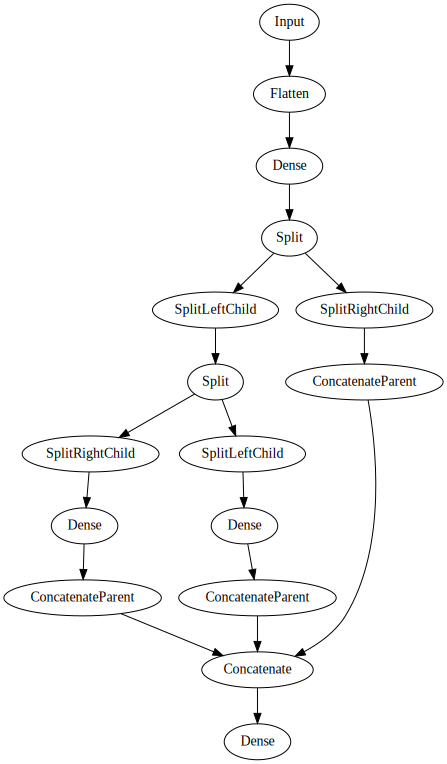

In [67]:
dot